**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Prepare a logger for debugging

In [2]:
import logging

# create logger
logger = logging.getLogger(__name__)

#Set level to logging.DEBUG to see CRITICAL, ERROR, WARNING, INFO and DEBUG statements
#Set level to logging.ERROR to see the CRITICAL & ERROR statements only
logger.setLevel(logging.DEBUG)

fileHandler = None
consoleHandler = None

if len(logger.handlers) > 0:
    for handler in logger.handlers:
        # makes sure no duplicate handlers are added
        if isinstance(handler, logging.FileHandler) and not isinstance(handler, logging.StreamHandler):
            fileHandler = handler
        elif isinstance(handler, logging.StreamHandler):
            fileHandler = handler
                
# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# create file handler which logs even info messages
if fileHandler is None:
    fileHandler = logging.FileHandler('P1_info_out.log')
    fileHandler.setLevel(logging.INFO)
    fileHandler.setFormatter(formatter)
    logger.addHandler(fileHandler)

# create console handler and set level to debug
if consoleHandler is None:
    consoleHandler = logging.StreamHandler()
    consoleHandler.setLevel(logging.DEBUG)
    consoleHandler.setFormatter(formatter)
    logger.addHandler(consoleHandler)

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


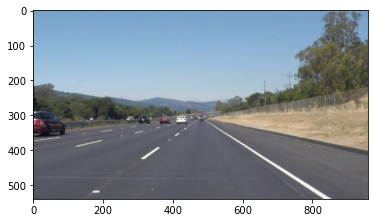

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

[`cv2.inRange()`](https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga48af0ab51e36436c5d04340e036ce981) for color selection  
[`cv2.fillPoly()`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#ga311160e71d37e3b795324d097cb3a7dc) for regions selection  
[`cv2.line()`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#ga7078a9fae8c7e7d13d24dac2520ae4a2) to draw lines on an image given endpoints  
[`cv2.addWeighted()`](https://docs.opencv.org/3.4/d2/de8/group__core__array.html#gafafb2513349db3bcff51f54ee5592a19) to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [20]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if logging.DEBUG >= logger.level:
        draw_lines(line_img, lines)
    draw_lane (line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

### Draw  Lane boundries 

This is the enhanced version of draw_lines in which we extrapolate the line from the line segments identified in Hough Transformation.

In [29]:
def draw_lane(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    x_points = [] # x_points[0] will present the left line while x_points[1] is the right line
    x_points.append([])
    x_points.append([])
    y_points = [] # y_points[0] will present the left line while y_points[1] is the right line
    y_points.append([])
    y_points.append([])
     
    ysize = image.shape[0]
    xsize = image.shape[1]

    for line in lines:
        for x1,y1,x2,y2 in line:
            slop = (y2-y1)/(x2-x1)
            if slop < 0 and x1 < xsize/2 and x2 < xsize/2 : # -ve slop is left line
                x_points[0].append (x1)
                x_points[0].append (x2)
                y_points[0].append (y1)
                y_points[0].append (y2)
            elif slop >= 0 and x1 >= xsize/2 and x2 >= xsize/2 : # +ve slop is right line
                x_points[1].append (x1)
                x_points[1].append (x2)
                y_points[1].append (y1)
                y_points[1].append (y2)
    
    # Identify left line
    x = np.array(x_points[0])
    y = np.array(y_points[0])
    line_fit = np.polyfit(x, y, 1)
    
    # y = mx + c 
    # x = (y - c)/m 
    # So we get x at the point in the image = ysize -1 to draw complete lines
    m, c = line_fit
    left_line = np.array([int((ysize -1 -c)/m), ysize -1, int((min(y) -c)/m), min(y)])
    
    #f = np.poly1d(line_fit)                 
    #left_line = np.array([min(x), int(f(min(x))), max(x), int(f(max(x)))])
    logger.debug('left line segments are \n x: %s \n y: %s \n and line is \n %s', x, y, left_line)
    
    # Identify right line
    x = np.array(x_points[1])
    y = np.array(y_points[1])
    line_fit = np.polyfit(x, y, 1)
    
    m, c = line_fit
    right_line = np.array([int((ysize -1 -c)/m), ysize -1, int((min(y) -c)/m), min(y)])

    #f = np.poly1d(line_fit)                 
    #right_line = np.array ([min(x), int(f(min(x))), max(x), int(f(max(x)))])
    logger.debug('right line segments are \n x: %s \n y: %s \n and line is \n %s', x, y, right_line)
    
    lane_lines = np.array([[left_line, right_line]]) 
    logger.debug('lane lines are : %s', lane_lines)
    
    draw_lines (img, lane_lines, color, thickness)                      

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Parameter Tuning

In the following section we will start build the pipeline one step at a time and see the outcome of it so we can tune the image outcome at each stage.

### Step 1. Convert image to Gray image

2020-09-30 01:10:54,699 - __main__ - INFO - Image: test_images/solidWhiteRight.jpg is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


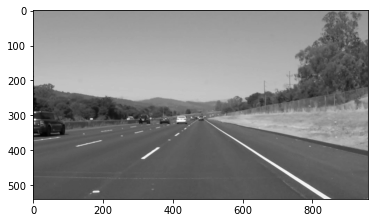

In [6]:
initial_img = image
gray_image = grayscale (image)
image_name = 'test_images/solidWhiteRight.jpg'
logger.info('Image: %s is: %s with dimensions: %s', image_name, type(image), image.shape)
if logging.DEBUG >= logger.level:
    plt.imshow(gray_image,  cmap='gray')

### Step 2. Blur the image
Blur the image with a Kernel size of 1

- **input:** gray image
- **output** blured gray image: the gray image after bluring it.

2020-09-30 01:10:54,862 - __main__ - INFO - Kernel_size tested at: 1 


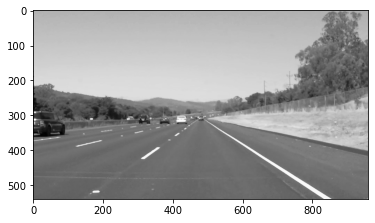

In [7]:
kernel_size = 1
logger.info('Kernel_size tested at: %s ',kernel_size)
blur_gray_image = gaussian_blur (gray_image, kernel_size)

if logging.DEBUG >= logger.level:
    plt.imshow(blur_gray_image,  cmap='Greys_r')

### Step 3. Identify Image Edges
Identify and show image edges using `canny ()` method with parameters:
```
low_threshold = 100
high_threshold = 200
```
- **input:** blured gray image: the gray image after bluring it.
- **output** edges image: the image with only the edges on it

2020-09-30 01:10:55,034 - __main__ - INFO - Canny parameters: low_threshold tested at: 100 - high_threshold tested at: 200 


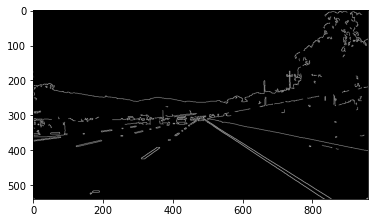

In [8]:
# Define our parameters for Canny and apply
low_threshold = 100
high_threshold = 200
logger.info('Canny parameters: low_threshold tested at: %s - high_threshold tested at: %s ',low_threshold, high_threshold)

edges_image = canny(blur_gray_image, low_threshold, high_threshold)
if logging.DEBUG >= logger.level: 
    plt.imshow(edges_image,  cmap='gray')

### Step 4. Apply Mask Region
Use a mask region of 4 points for marking the intrest area. The 4 points are:

for image dimension of hight = ysize and width = xsize
```
point1 = (0,ysize),
point2 = (xsize*.49, ysize*.58), #a point to the left of the center point by 1 = 50% 1 1%
point3 = (xsize*.51, ysize*.58), #a point to the right of the center point by 1% = 50% + 1%
point4 = (xsize,ysize)
```

- **input:** edges image: the image with only the edges on it
- **output** masked edges image: the edges of the picture shown only in the mask region

2020-09-30 01:10:55,196 - __main__ - INFO - The masked region vertices of the image is: [[[  0 540]
  [470 313]
  [489 313]
  [960 540]]] 
2020-09-30 01:10:55,198 - __main__ - DEBUG - The masked region vertices of the image is: [[[  0 540]
  [470 313]
  [489 313]
  [960 540]]] 


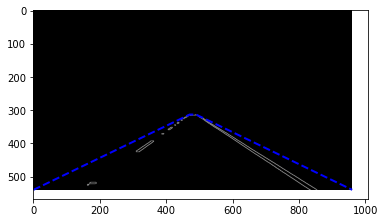

In [9]:
# Identify a region of 4 points for interest.
imshape = image.shape
ysize = image.shape[0]
xsize = image.shape[1]
vertices = np.array([[(0,ysize),(xsize*.49, ysize*.58), (xsize*.51, ysize*.58), (xsize,ysize)]], dtype=np.int32)
logger.info('The masked region vertices of the image is: %s ',vertices)

masked_edges = region_of_interest(edges_image, vertices)
if logging.DEBUG >= logger.level:
    logger.debug('The masked region vertices of the image is: %s ',vertices)
    plt.imshow(masked_edges, cmap='gray')
    x = [0, xsize*.49, xsize*.51, xsize]
    y = [ysize, ysize*.58, ysize*.58, ysize]
    plt.plot(x, y, 'b--', lw=2)    

### Step 5. Apply Hough Transform

To identify the lines from the edges picture of the masked region, it is goinf to use hough transform to identify lines using the following parameters:
```
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 5 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments
```


- **input:** masked edges image: the edges of the picture shown only in the mask region
- **output** marked red lines: the edges of the picture convereted to red lines.

2020-09-30 02:41:11,456 - __main__ - INFO - The Hough parameters used are: rho=2, theta=0.017453292519943295, threshold=15, min_line_length=5, max_line_gap=10
2020-09-30 02:41:11,460 - __main__ - DEBUG - left line segments are 
 x: [310 357 318 362 463 475 410 464 406 467 419 439 310 355 409 419 352 362
 461 475 406 415 426 434 407 468 164 171] 
 y: [423 392 425 393 321 313 359 319 358 314 351 339 422 392 359 352 402 394
 319 317 357 351 346 340 359 314 526 517] 
 and line is 
 [143 539 474 313]
2020-09-30 02:41:11,462 - __main__ - DEBUG - right line segments are 
 x: [624 834 502 854 490 617 652 710 487 772 800 833 504 524 833 854 507 848] 
 y: [402 539 319 539 313 396 420 457 313 498 518 539 320 332 525 538 322 535] 
 and line is 
 [843 539 489 313]
2020-09-30 02:41:11,462 - __main__ - DEBUG - lane lines are : [[[143 539 474 313]
  [843 539 489 313]]]
2020-09-30 02:41:11,464 - __main__ - DEBUG - The masked region vertices of the image is: [[[  0 540]
  [470 313]
  [489 313]
  [960 54

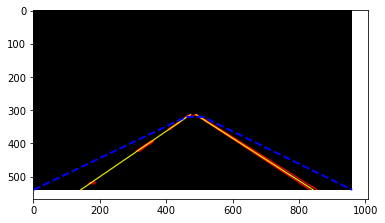

In [30]:
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 5 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments
logger.info('The Hough parameters used are: rho=%s, theta=%s, threshold=%s, min_line_length=%s, max_line_gap=%s', \
            rho, theta, threshold, min_line_length, max_line_gap)

lines_edges = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

if logging.DEBUG >= logger.level:
    logger.debug('The masked region vertices of the image is: %s ',vertices)
    plt.imshow(lines_edges)
    plt.plot(x, y, 'b--', lw=2)    

### Step 6. 

Drawing the lines baded on the lines images

- **input:** marked red lines: the edges of the picture convereted to red lines.
- **output** lines image: Returns an image with hough lines drawn.

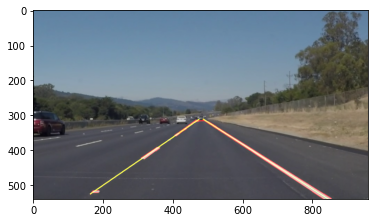

In [26]:
lines_image = weighted_img(lines_edges, initial_img)

if logging.DEBUG >= logger.level:
    plt.imshow(lines_image)
    x = [0, 460, 510, imshape[1]]
    y = [imshape[0], 320, 320, imshape[0]]
    # plt.plot(x, y, 'b--', lw=2)

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!